# DESAFIO - Aula_23: Matriz_Custo e Curva_Lucro

Base de Dados <br>
Link: https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv <br>
Resumo: O conjunto de dados está relacionado a campanhas de marketing direto (chamadas telefônicas) de uma instituição bancária portuguesa. A variável resposta (y) é binária e indica se o cliente subscreveu um depósito a prazo (1-Sim, 0-Não). <br>
Objetivo: Ajustar um modelo de regressão logística, em uma base de treinamento, para a resposta binária, fazer a previsão desta resposta e avaliar a qualidade de ajuste do modelo em uma base de teste.


## Importando os Dados

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

data = pd.read_csv('C:/Users/crrodr/Desktop/Tera - Data Science/Bases para exemplos-exercicios/Aula_23-Matriz_Custo-Curva_Lucro/bank_desafio/banking.csv',header=0)
#drop na
data = data.dropna()
lista = ('age','education','contact','month','day_of_week','duration',
        'campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx', 
        'euribor3m','nr_employed')
#exclui algumas variáveis da análise
for col in lista:
    data.drop(col, axis=1, inplace=True)
print(data.shape)

(41188, 7)


O conjunto de dados fornece a informação dos clientes do banco. Inclui 41,188 registros e 16 variáveis.

In [4]:
data.head()

,job,marital,default,housing,loan,poutcome,y
0,blue-collar,married,unknown,yes,no,nonexistent,0
1,technician,married,no,no,no,nonexistent,0
2,management,single,no,yes,no,success,1
3,services,married,no,no,no,nonexistent,0
4,retired,married,no,yes,no,success,1


# Parte_1: Tratando os dados

- ## Var resposta

Transformando a variável Income-Renda em 0's and 1's

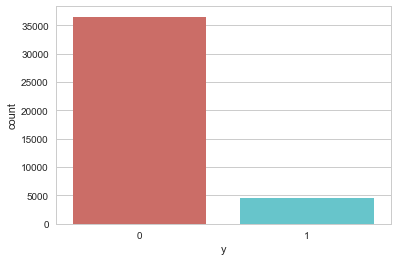

In [5]:
# grafico de barras para a variável dependente
sns.countplot(x='y',data=data, palette='hls')
plt.show()

A proporção de 1's é de aproximandamente 14%

- ## Verificando valores missing

In [6]:
data.isnull().sum()

job         0
marital     0
default     0
housing     0
loan        0
poutcome    0
y           0
dtype: int64

Não há dados missing na base de análise

- ## job: trabalho do cliente

Tem muitas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

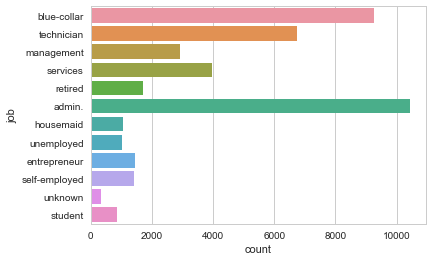

In [7]:
# grafico de barras para a variável customer job 
sns.countplot(y='job',data=data)
plt.show()
#há muitas categorias: vamos agrupar as classes que tem menos obs

In [8]:
# unindo as categorias de trabalho, para depois não criar muitas dummys
def agrupa(job):
    if job in ['blue-collar']:
        return 'blue_collar'
    elif job in ['technician']:
        return 'technician'
    elif job in ['admin.']:
        return 'admin' 
    elif job in ['management']:
        return 'management'
    elif job in ['services']:
        return 'services'
    
    else: 
        return 'other'    

In [9]:
data['job'] = data['job'].apply(agrupa)

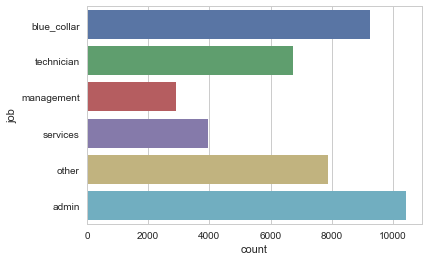

In [10]:
# grafico de barras para a variável customer job 
sns.countplot(y='job',data=data)
plt.show()

- ## Marital: estado civil

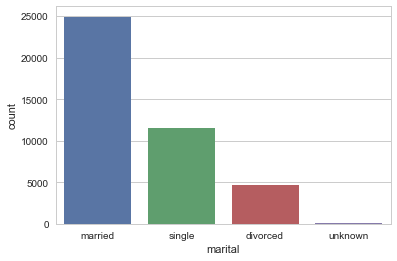

In [11]:
sns.countplot(x='marital',data=data)
plt.show()

A categoria unknown tem poucas obs - vamos juntá-la com a cat divorced

In [12]:
def agrupa1(marital):
    if marital in ['unknown']:
        return 'divorced'
    else: 
        return marital   

In [13]:
data['marital'] = data['marital'].apply(agrupa1)

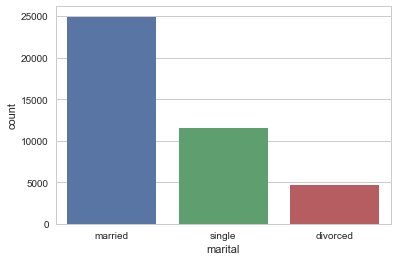

In [14]:
sns.countplot(x='marital',data=data)
plt.show()

- ## Default - crédito em default

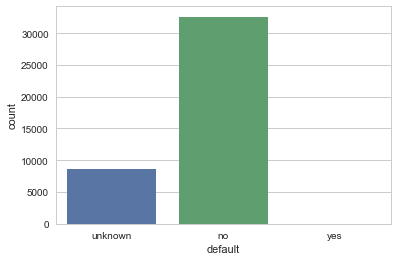

In [15]:
sns.countplot(x='default',data=data)
plt.show()

A categoria yes tem poucas obs - vamos juntá-la com a cat unknown

In [16]:
def agrupa2(default):
    if default in ['yes']:
        return 'unknown'
    else: 
        return default   

In [17]:
data['default'] = data['default'].apply(agrupa2)

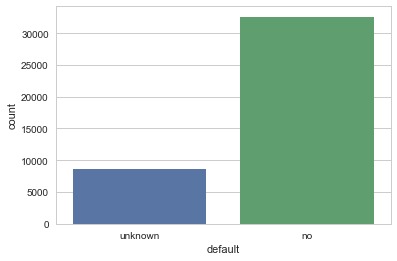

In [18]:
sns.countplot(x='default',data=data)
plt.show()

- ## housing: emprestimo imobiliario

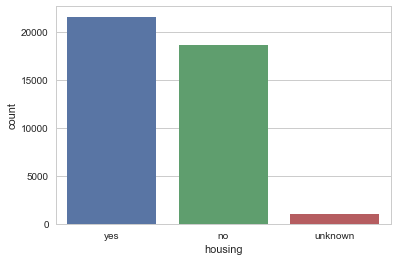

In [19]:
sns.countplot(x='housing',data=data)
plt.show()

Está tudo OK

- ## loan: emprestimo pessoal

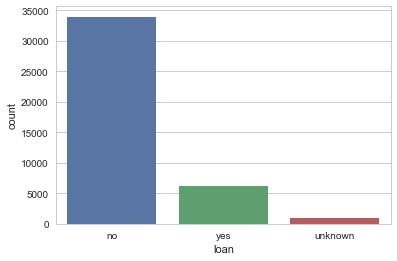

In [20]:
sns.countplot(x='loan',data=data)
plt.show()

Está tudo OK

- ## poutcome: resultado da campanha de marketing anterior

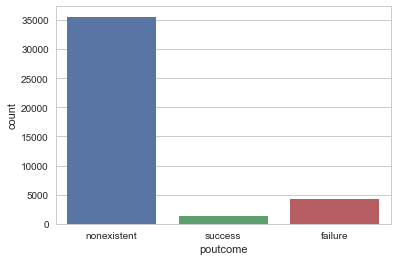

In [21]:
sns.countplot(x='poutcome',data=data)
plt.show()

Está tudo OK

- ## Criando Dummys

Crie variáveis dummy, que são variáveis com apenas dois valores, zero e um. <br>
Nos modelos de regressão logística, a codificação de todas as variáveis independentes-categoricas como variáveis dummy permite uma fácil interpretação e cálculo da odds ratios e aumenta a estabilidade e a importância dos coeficientes.

In [22]:
data.dtypes

job         object
marital     object
default     object
housing     object
loan        object
poutcome    object
y            int64
dtype: object

In [23]:
#list of columns with dtype: object
#axes[1] coluna
#axes[0] linha
categorical_features = data.select_dtypes(include=['object']).axes[1] # retorna as vars que são do tipo objeto

# unique: retorna os valores únicos
# nunique: retorna o número de valores únicos
for col in categorical_features:
    print (col, data[col].nunique()) # retorna as vars que são do tipo objeto e a quantidade de categorias em cada uma delas

job 6
marital 3
default 2
housing 3
loan 3
poutcome 3


In [24]:
#criando dummys para as variáveis categoricas
for col in categorical_features:
    data = pd.concat([data, pd.get_dummies(data[col], prefix=col, prefix_sep='_')], axis=1)
    data.drop(col, axis=1, inplace=True)

In [25]:
data.columns

Index(['y', 'job_admin', 'job_blue_collar', 'job_management', 'job_other',
       'job_services', 'job_technician', 'marital_divorced', 'marital_married',
       'marital_single', 'default_no', 'default_unknown', 'housing_no',
       'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [26]:
data.head()

,y,job_admin,job_blue_collar,job_management,job_other,job_services,job_technician,marital_divorced,marital_married,marital_single,default_no,default_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1
3,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0
4,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1


# Parte_2: Dividindo a base em train e test

In [27]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

In [28]:
print(X_train.shape, X_test.shape)

(30891, 20) (10297, 20)


# Parte_3: Ajustar, Prever e Validar um modelo de Regressão Logística usando sklearn

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import pylab as pl


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [30]:
X1_train = X_train[['poutcome_success' , 'default_no' , 'job_other' , 'poutcome_failure' , 'marital_single' , 'job_blue_collar' ,
       'job_services' , 'job_technician' , 'marital_divorced']]
X1_test = X_test[['poutcome_success' , 'default_no' , 'job_other' , 'poutcome_failure' , 'marital_single' , 'job_blue_collar' ,
       'job_services' , 'job_technician' , 'marital_divorced']]

model = LogisticRegression()
model.fit(X1_train, y_train)

p_test1 = model.predict(X1_test)



In [31]:
# Calculando confusion matrix, AUC, precision e recall para base de treinamento
#model.fit(Xtrain, Ttrain)
cnf_matrix1 = confusion_matrix(y_test, p_test1)
print ("\n\n ---Base de Teste---")
print ("\n\n ---Matriz de Confusão---")
print(cnf_matrix1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X1_test, y_test)))
#0,8986112459939788

print ("\n\n ---Logistic Model---")
logit_roc_auc2 = roc_auc_score(y_test, model.predict(X1_test))
print ("Logistic AUC = %2.2f" % logit_roc_auc2)
print(classification_report(y_test, p_test1))



 ---Base de Teste---


 ---Matriz de Confusão---
[[9038  103]
 [ 942  214]]
Accuracy of logistic regression classifier on test set: 0.90


 ---Logistic Model---
Logistic AUC = 0.59
             precision    recall  f1-score   support

          0       0.91      0.99      0.95      9141
          1       0.68      0.19      0.29      1156

avg / total       0.88      0.90      0.87     10297



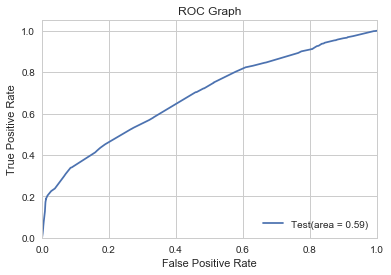

In [32]:
# Plotando o curva ROC para a base de teste
fpr2, tpr2, thresholds = roc_curve(y_test, model.predict_proba(X1_test)[:,1])
plt.plot(fpr2, tpr2, label='Test(area = %0.2f)' % logit_roc_auc2)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

## Matriz de Custo e Curva de Lucro



O conjunto de dados está relacionado a campanhas de marketing direto (chamadas telefônicas) de uma instituição bancária portuguesa. A variável resposta (y) é binária e indica se o cliente subscreveu um depósito a prazo (1-Sim, 0-Não). 
O custo da ligação direta para o cliente é de 10 reais, mas se o cliente subescreve ao depósito temos uma beneficio de 100-10=90

In [33]:
###### Matriz de Custo
cost_TP = 90; cost_FP = -10; cost_FN = 0; cost_TN = 0;
cb_matrix = np.array([[cost_TN, cost_FP],[cost_FN, cost_TP]])
cb_matrix

array([[  0, -10],
       [  0,  90]])

## Calculando o lucro

In [34]:
# Calcula a probabilidade para a base de teste
predict_prob = model.predict_proba(X1_test)[:,1]
# Cria um data frame com a probabilidade predita e a y_real
df = pd.DataFrame( {"predict_prob":predict_prob, "true_value":y_test} )
# Ordena o data frame df pela prob predita
df.sort_values(by="predict_prob", inplace=True)

In [35]:
# Defini um ponto de corte para o cálculo do lucro
p = 0.1
label_p = df.predict_prob >= p    
counf = confusion_matrix(df.true_value, label_p)
lucro = (counf * cb_matrix).sum()
print(lucro)

30090


In [36]:
# e se eu definir outro ponto de corte
p = 0.2
label_p = df.predict_prob >= p    
counf = confusion_matrix(df.true_value, label_p)
lucro = (counf * cb_matrix).sum()
print(lucro)

19750


### Como podemos fazer para encontrar o ponto de corte ótimo, ou seja, o que retorno o maior lucro

In [37]:
#Calcula o lucro para "cada" ponto de corte 
predict_prob = model.predict_proba(X1_test)[:,1]
df = pd.DataFrame( {"predict_prob":predict_prob, "true_value":y_test} )
df.sort_values(by="predict_prob", inplace=True)

def profit_gain(predict_prob, true_value, p_step):
    lucro = []
    p=[0]
    while p[-1]+p_step<=1:
        label_p = (df.predict_prob >= p[-1]).astype(int)    
        counf = confusion_matrix(df.true_value, label_p)
        lucro.append( (counf * cb_matrix).sum() )
        p.append(p[-1]+p_step)
    return lucro, p

# Agora vamos tornar o processo mais automatico

In [38]:
# Carregando pacotes necessários
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [39]:
# ajustando alguns modelos
model_1 = LR()
model_1.fit(X_train, y_train)

model_2 = RF()
model_2.fit(X_train, y_train)

model_3 = GBC()
model_3.fit(X_train, y_train)

models = model_1, model_2, model_3

In [40]:
#Calcula o locro para "cada" ponto de corte e depois plota o lucro versus a probabilidade
def profit_gain(predict_prob, true_value, p_step):
    df = pd.DataFrame( {"predict_prob":predict_prob, "true_value":true_value} )
    df.sort_values(by="predict_prob", inplace=True)
    lucro = []
    p=[0]
    while p[-1]<=1:
        label_p = (df.predict_prob >= p[-1]).astype(int)    
        counf = confusion_matrix(df.true_value, label_p)
        lucro.append( (counf * cb_matrix).sum() )
        p.append(p[-1]+p_step)
    return lucro, p

def plot_profit( predict_prob, true_value, p_step ):
    array_lucro, p = profit_gain( predict_prob, true_value, p_step )
    plt.plot(p[:-1], array_lucro)
    return None

def multi_plot( models, X, y_true, p_step):
    for i in models:
        predict_prob = i.predict_proba( X )[:,1]
        plot_profit( predict_prob, y_true, p_step )
    plt.legend([i.__class__.__name__ for i in models])
    plt.show()

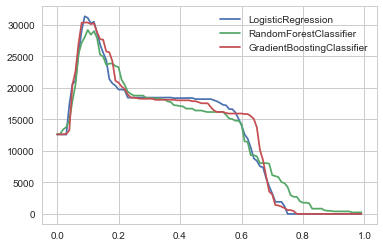

In [41]:
multi_plot( models=models, X=X_test, y_true=y_test, p_step=0.01)

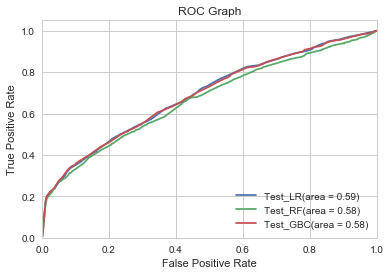

In [42]:
# Plotando curva ROC para todos os modelos
fpr1, tpr1, thresholds1 = roc_curve(y_test, model_1.predict_proba(X_test)[:,1])
logit_roc_auc1 = roc_auc_score(y_test, model_1.predict(X_test))
plt.plot(fpr1, tpr1, label='Test_LR(area = %0.2f)' % logit_roc_auc1)
#
fpr2, tpr2, thresholds2 = roc_curve(y_test, model_2.predict_proba(X_test)[:,1])
logit_roc_auc2 = roc_auc_score(y_test, model_2.predict(X_test))
plt.plot(fpr2, tpr2, label='Test_RF(area = %0.2f)' % logit_roc_auc2)
#
fpr3, tpr3, thresholds3 = roc_curve(y_test, model_3.predict_proba(X_test)[:,1])
logit_roc_auc3 = roc_auc_score(y_test, model_3.predict(X_test))
plt.plot(fpr3, tpr3, label='Test_GBC(area = %0.2f)' % logit_roc_auc3)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

Referências <br>
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8